### Import libraries


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from fiona.drvsupport import supported_drivers
supported_drivers['LIBKML'] = 'rw'
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import tabula
import re
from sklearn.preprocessing import LabelEncoder

### Load Datasets


- Read Delhi Shape File


In [3]:
# gdf = gpd.read_file("./assets/delhi.geojson") # outdated shape file
gdf = gpd.read_file("./datasets/delhi_wards.kml", driver='KML')
# source: https://data.opencity.in/dataset/delhi-wards-information

gdf = gdf[['Ward_No','geometry']]
gdf.columns = ["wardno","geometry"]
gdf = gdf.sort_values(by='wardno')

- Load delhi zones data


In [4]:
delhi_zones = pd.read_csv("./datasets/zone_data.txt")

def parse_row(row):
    text = row['Ward No. Ward Name Zone Name']
    ward_no_match = re.match(r"^(\d+)", text)
    ward_no = ward_no_match.group(1) if ward_no_match else None
    rest = text[len(ward_no):].strip() if ward_no else text
    words = rest.split()
    ward_name_words = []
    zone_name_words = []
    found_zone = False
    for word in words:
        if not found_zone and (word.isupper() or ("-" in word and all(part.isupper() for part in word.split("-")))):
            ward_name_words.append(word)
        else:
            found_zone = True
            zone_name_words.append(word)
    ward_name = " ".join(ward_name_words)
    zone_name = " ".join(zone_name_words)
    return pd.Series([ward_no, ward_name, zone_name])

delhi_zones = delhi_zones.apply(parse_row, axis=1)
delhi_zones.columns = ["wardno","ward","zone"]
delhi_zones['wardno'] = delhi_zones['wardno'].astype("int64")

- Load the state election commission delimitation 2022 dataset which has 250 wards and population data


In [5]:

SEC_ww_delimit_2022 = tabula.read_pdf("./datasets/wardwise_population_summary.pdf", pages="all")
df = pd.DataFrame(columns=["sno","acno","ac_name","wardno","ward","total_population","sc_population"])
for i in range(0,9):
    SEC_ww_delimit_2022[i].columns = ["sno","acno","ac_name","wardno","ward","total_population","sc_population"]
    df = pd.concat([df,SEC_ww_delimit_2022[i]], axis=0, ignore_index=True)
    df_cleaned = df[~df['ward'].astype(str).str.contains("Total", na=False)]
    df = df_cleaned
SEC_ww_delimit_2022 = df.copy(deep=True)
SEC_ww_delimit_2022['wardno'] = SEC_ww_delimit_2022['wardno'].astype("int64")

Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'
C:\Users\nodeX\AppData\Local\Temp\ipykernel_25888\1025190481.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,SEC_ww_delimit_2022[i]], axis=0, ignore_index=True)


- prepare to merge ward data with the shape file data


In [6]:
delhi_ww_pop = pd.merge(SEC_ww_delimit_2022, gdf, on='wardno')

- prepare to merge ward data with zones data


In [7]:
delhi_zww_pop = pd.merge(delhi_ww_pop,delhi_zones[['wardno','zone']], on='wardno')

In [8]:
delhi_zww_pop_gdf = gpd.GeoDataFrame(delhi_zww_pop)

In [9]:
le = LabelEncoder()
delhi_zww_pop_gdf['zoneno'] = le.fit_transform(delhi_zww_pop_gdf['zone'])

In [10]:
le.classes_

array(['Central Zone', 'City S.P.Zone', 'Civil Line', 'Karolbagh',
       'Keshavpuram', 'Najafgarh Zone', 'Narela', 'Rohini',
       'Shahdara North Zone', 'Shahdara South Zone', 'South Zone',
       'West Zone'], dtype=object)

### Vizualization

- initial vizualization


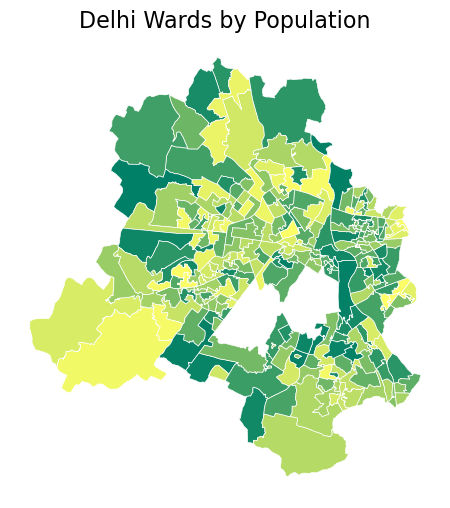

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
delhi_zww_pop_gdf.plot(
    column='total_population',
    ax=ax,
    cmap='summer',
    linewidth=0.5,
    edgecolor="white",
    missing_kwds={
        'color': 'lightgray',
    }
)

ax.set_title('Delhi Wards by Population', fontsize=16)
ax.axis('off')
plt.show()

- zone wise population gradient
  - first we get the zone codes
  - then we set the base colours for the zones and keep it in a variable. We create the color map from it.


In [12]:
zones = delhi_zww_pop_gdf['zoneno'].unique()
zones.sort()
base_colors = sns.color_palette('husl', n_colors=len(zones))
zone_color_map = dict(zip(zones, base_colors))
base_colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.903599057664843, 0.511987276335809, 0.19588350060161624),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20312757197899856, 0.6881249249803417, 0.5177618167447304),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21786710662428366, 0.6656671601322256, 0.7482809385065813),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9633321742064956, 0.40643825645731757, 0.7592537599568671)]

- Then we create the zone wise normalized population distribution table of the df. We get all the zones and the population within each zones this way
- We get the shaded colour by using the shades of base colors and normalized population value for each zone


In [13]:
delhi_zww_pop_gdf['zone'].unique()

array(['Narela', 'Civil Line', 'Rohini', 'Keshavpuram', 'City S.P.Zone',
       'Karolbagh', 'West Zone', 'Najafgarh Zone', 'Central Zone',
       'South Zone', 'Shahdara South Zone', 'Shahdara North Zone'],
      dtype=object)

In [14]:
delhi_zww_pop_gdf['norm_pop'] = (
    delhi_zww_pop_gdf.groupby('zoneno')['total_population']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-5))
)

def get_shaded_color(base_color, intensity):
    return tuple((1 - intensity) * 0.9 + intensity * c for c in base_color)

delhi_zww_pop_gdf['color'] = delhi_zww_pop_gdf.apply(
    lambda row: get_shaded_color(zone_color_map[row['zoneno']], row['norm_pop']),
    axis=1
)


#### Zone Wise Distribution of Population


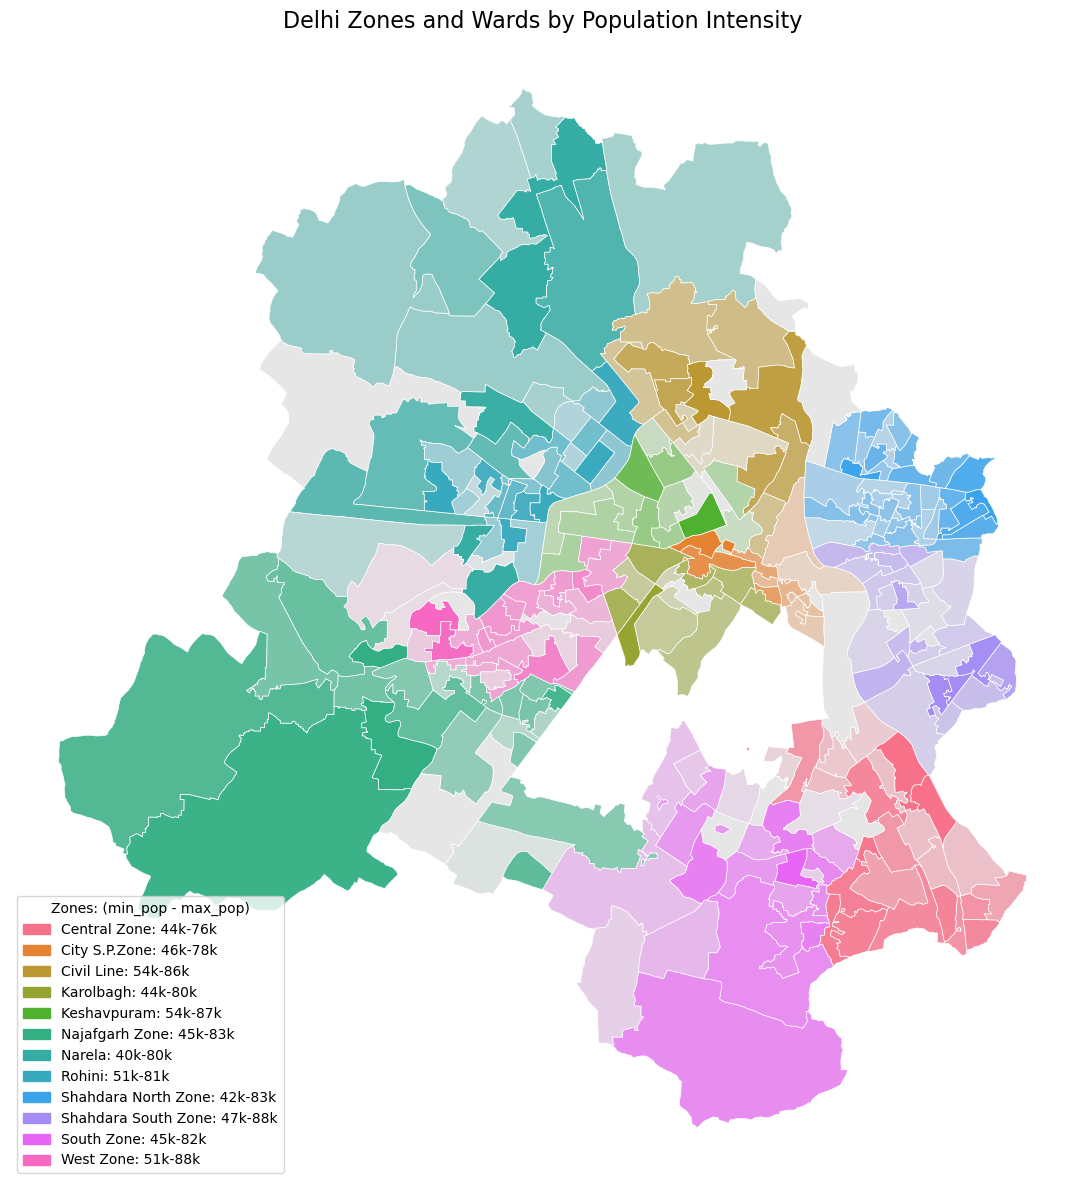

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
zone_pop = delhi_zww_pop_gdf.groupby('zoneno')['total_population'].agg(['min', 'max'])

delhi_zww_pop_gdf.plot(
    color=delhi_zww_pop_gdf['color'],
    ax=ax,
    linewidth=0.5,
    edgecolor='white'
)

# Title and legend notes
ax.set_title('Delhi Zones and Wards by Population Intensity', fontsize=16)
ax.axis('off')

from matplotlib.patches import Patch
handles = [
    Patch(color=zone_color_map[z], 
          label=f'{le.classes_[z]}: {int(zone_pop.loc[z,"min"]/1000)}k-{int(zone_pop.loc[z,"max"]/1000)}k')
    for z in zones
]
ax.legend(handles=handles, title='Zones: (min_pop - max_pop)', loc='lower left')

plt.tight_layout()
plt.show()

In [16]:
zones = delhi_zww_pop_gdf['zoneno'].unique()
zones.sort()

# Base colors
base_colors = sns.color_palette('husl', n_colors=len(zones))
zone_color_map = dict(zip(zones, base_colors))

# Normalize population within zone
delhi_zww_pop_gdf['norm_pop'] = (
    delhi_zww_pop_gdf.groupby('zoneno')['total_population']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-5))
)

# Get min/max population per zone
zone_pop_range = delhi_zww_pop_gdf.groupby('zoneno')['total_population'].agg(['min', 'max']).to_dict('index')

# Blend with white for lightness variation
def get_shaded_color(base_color, intensity):
    return tuple((1 - intensity) * 0.95 + intensity * c for c in base_color)

# Assign final color
delhi_zww_pop_gdf['color'] = delhi_zww_pop_gdf.apply(
    lambda row: get_shaded_color(zone_color_map[row['zoneno']], row['norm_pop']),
    axis=1
)

C:\Users\nodeX\AppData\Local\Temp\ipykernel_25888\1770161552.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


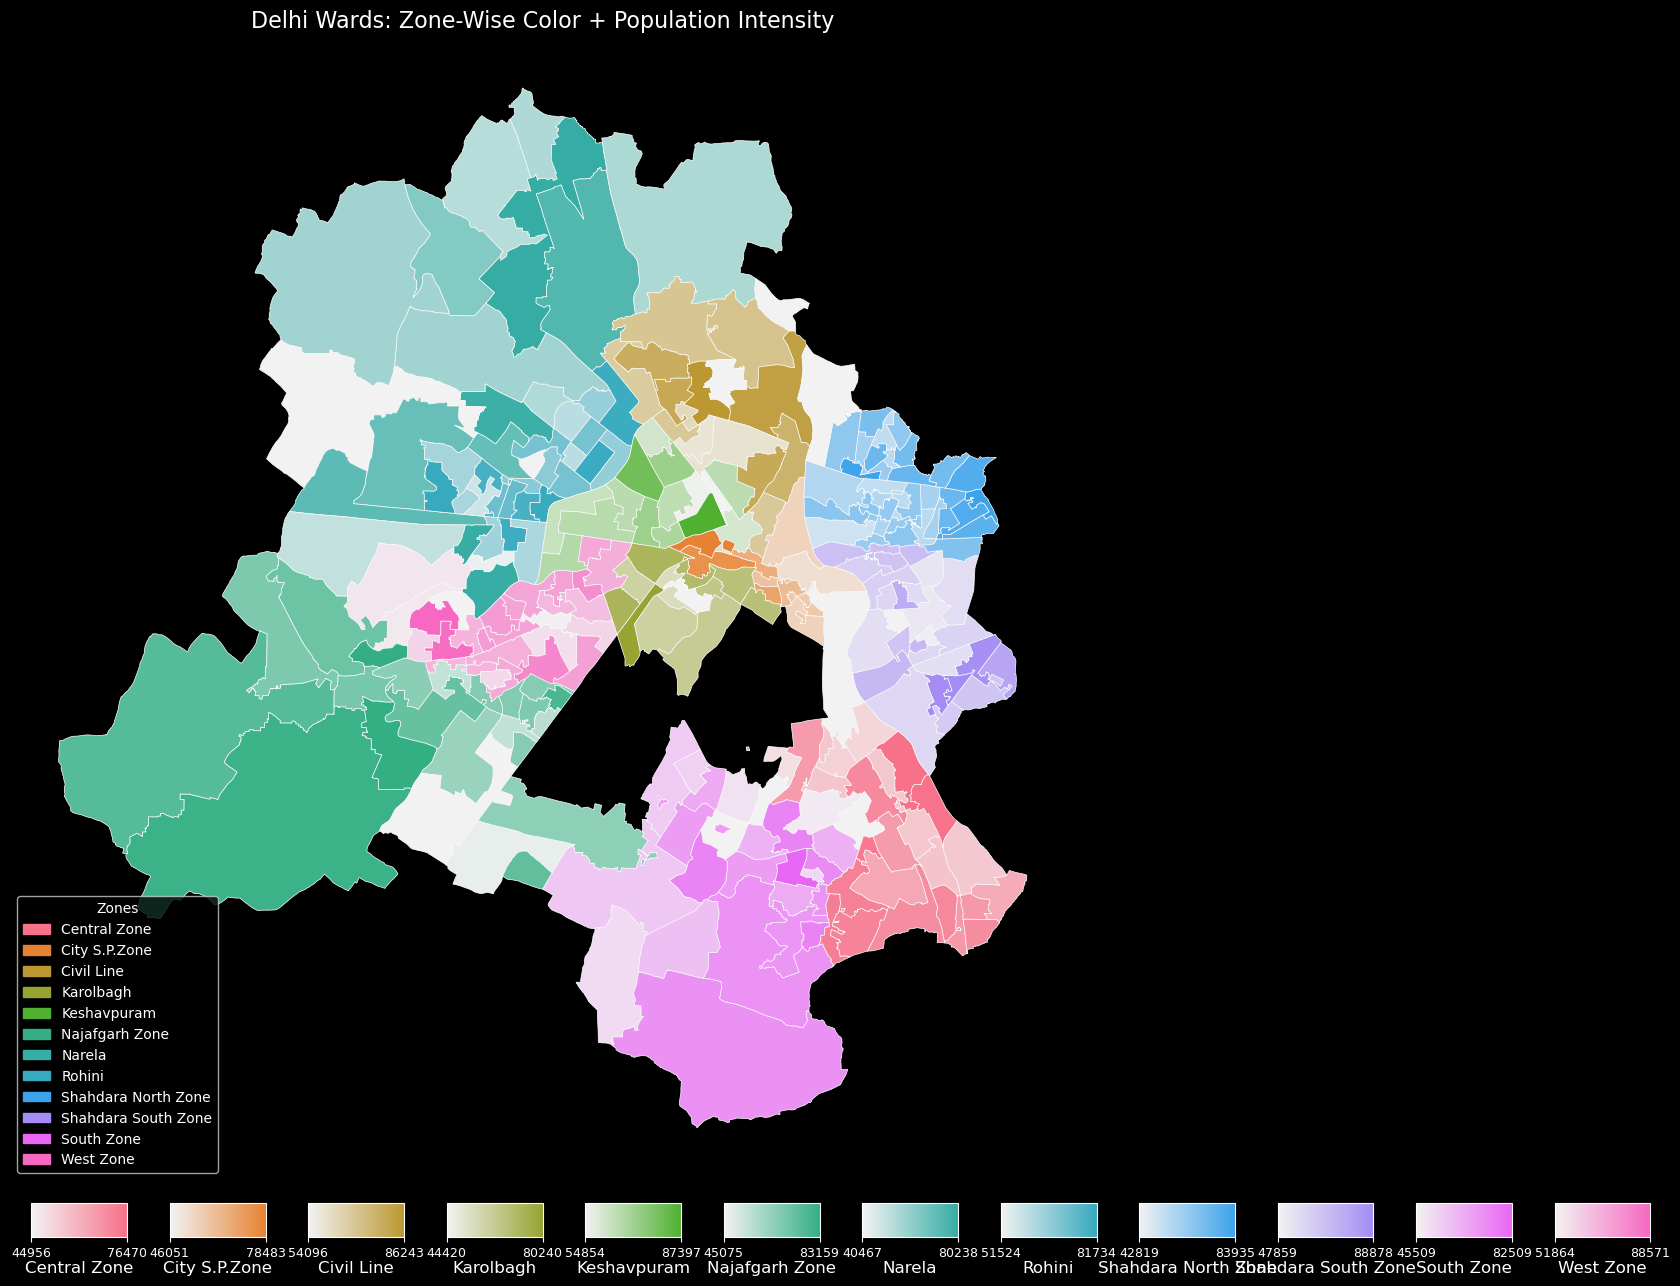

In [19]:
# Plot map
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
plt.style.use('dark_background')
delhi_zww_pop_gdf.plot(
    color=delhi_zww_pop_gdf['color'],
    ax=ax,
    linewidth=0.5,
    edgecolor='white',
)
ax.set_title('Delhi Wards: Zone-Wise Color + Population Intensity', fontsize=16)
ax.axis('off')
ax.set_facecolor("black")
# Legend for zones
zone_legend = [
    Patch(color=zone_color_map[z], label=f'{le.classes_[z]}')
    for z in zones ]
leg1 = ax.legend(handles=zone_legend, title='Zones', loc='lower left')
ax.set_facecolor('black')    
# Create custom colorbars for population intensity per zone
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for i, z in enumerate(zones):
    # Axes inset for each colorbar arranged in a row
    axins = inset_axes(ax, width="3%", height="1%", loc='lower left',
                       bbox_to_anchor=(0.02 + i * 0.13, -0.05, 3, 3),
                       bbox_transform=ax.transAxes, borderpad=0)

    cmap = mcolors.LinearSegmentedColormap.from_list(
        f'zone{z}_cmap',
        [get_shaded_color(zone_color_map[z], i) for i in [0, 1]]
    )
    norm = mcolors.Normalize(vmin=zone_pop_range[z]['min'], vmax=zone_pop_range[z]['max'])
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=axins, orientation='horizontal')
    cb.ax.tick_params(labelsize=9)
    cb.set_label(f'{delhi_zww_pop_gdf.loc[delhi_zww_pop_gdf['zoneno']==z]['zone'].unique()[0]}', fontsize=12, labelpad=1)
    cb.set_ticks([zone_pop_range[z]['min'], zone_pop_range[z]['max']])

plt.tight_layout()
plt.show()

In [18]:
delhi_zww_pop_gdf.to_file("./datasets/delhi_zww_pop_gdf.json", driver="GeoJSON")

In [63]:
delhi_zww_pop_gdf 

,sno,acno,ac_name,wardno,ward,total_population,sc_population,geometry,zone,zoneno,norm_pop,color
0,1.0,1.0,NARELA,1,NARELA,54908,11618,"POLYGON ((77.08542 28.88213, 77.08545 28.88213...",Narela,6,0.363104,"(0.6814657138012856, 0.8509854177083235, 0.838..."
1,NaN,NaN,NaN,2,BANKNER,52874,12650,"POLYGON ((77.06256 28.87002, 77.06295 28.86979...",Narela,6,0.311961,"(0.7192884918726231, 0.8649315198052192, 0.854..."
2,NaN,NaN,NaN,3,HOLAMBI KALAN,80238,18845,"POLYGON ((77.12671 28.84566, 77.12441 28.84558...",Narela,6,1.0,"(0.21044753850778555, 0.6773105081142398, 0.64..."
3,NaN,NaN,NaN,4,ALIPUR,74449,15359,"POLYGON ((77.12603 28.76161, 77.12603 28.76161...",Narela,6,0.854442,"(0.31809555338240353, 0.7170027328138115, 0.68..."
4,NaN,NaN,NaN,5,BAKHTAWARPUR,55144,10926,"POLYGON ((77.20565 28.79539, 77.20565 28.79539...",Narela,6,0.369038,"(0.677077230209921, 0.8493672859016042, 0.8368..."
...,...,...,...,...,...,...,...,...,...,...,...,...
245,68.0,70.0,KARAWAL NAGAR,246,SRI RAM COLONY,83347,3146,"POLYGON ((77.25377 28.71249, 77.25391 28.71246...",Shahdara North Zone,8,0.985699,"(0.24324515360033933, 0.6440257754935307, 0.92..."
246,NaN,NaN,NaN,247,SADATPUR,60181,5739,"POLYGON ((77.26761 28.72272, 77.26744 28.72232...",Shahdara North Zone,8,0.422269,"(0.6472296278328338, 0.8189221159227862, 0.939..."
247,NaN,NaN,NaN,248,KARAWAL NAGAR-WEST,69926,8413,"POLYGON ((77.2762 28.73578, 77.27644 28.73563,...",Shahdara North Zone,8,0.659281,"(0.477289685615979, 0.7453502935329435, 0.9342..."
248,NaN,NaN,NaN,249,SONIA VIHAR,65031,6071,"POLYGON ((77.2604 28.73427, 77.26031 28.73361,...",Shahdara North Zone,8,0.540228,"(0.562652027037375, 0.7823060729683751, 0.9370..."


 ### Enter PyDeck

In [20]:
import pydeck as pdk

In [27]:
track = gpd.read_file("./datasets/delhi_zww_pop_gdf.json")
track['total_population'] = track['total_population'].astype("int64")
track['norm_pop'] = track['norm_pop'].astype("float32")

In [53]:
track.columns

Index(['sno', 'acno', 'ac_name', 'wardno', 'ward', 'total_population',
       'sc_population', 'zone', 'zoneno', 'norm_pop', 'color', 'geometry'],
      dtype='object')

In [30]:
INITIAL_VIEW_STATE = pdk.ViewState(latitude=28.61, 
                                   longitude=77.23, 
                                   zoom=9, max_zoom=16, pitch=60, bearing=0)

In [78]:
delhi_zww_pop_deck = pdk.Layer(
    "GeoJsonLayer",
    track,
    opacity=0.1,
    stroked=False,
    filled=True,
    extruded=True,
    wireframe=False,
    pickable=False,
    auto_highlight=False,
    highlight_color=None,
    get_elevation="total_population/20",
    get_fill_color="[255, 255, norm_pop*255]",
    get_line_color=[255, 255, 255],
)

In [80]:
r = pdk.Deck(layers=[delhi_zww_pop_deck], initial_view_state=INITIAL_VIEW_STATE)

# Exporting as an html file
r.to_html("./assets/filename.html")

TypeError: Deck.__init__() got an unexpected keyword argument 'controller'